Imports

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.path_utils import get_project_root

Load data

In [11]:
models = {
    "LSTM":              r"\models\LSTM_search\cv_results.csv",
    "LSTM_STFT":         r"\models\LSTM_STFT_search\cv_results.csv",
    "LSTM_STFT_Dense":   r"\models\LSTM_STFT_Dense_search\cv_results.csv",
    "ANN":               r"\models\ANN_search\cv_results.csv",
    "ANN_STFT":          r"\models\ANN_STFT_search\cv_results.csv",
}

dfs = []
for model, path in models.items():
    file_path = str(get_project_root()) + path
    df = pd.read_csv(file_path)
    df["model"] = model
    dfs.append(df)

df_all = pd.concat(dfs)
print(df_all.head())

  architecture  preproc_variant  val_subject        f1  hp_trial model
0         LSTM                1            1  0.542928  trial_05  LSTM
1         LSTM                1            2  0.731716  trial_05  LSTM
2         LSTM                1            3  0.645994  trial_05  LSTM
3         LSTM                1            4  0.647873  trial_05  LSTM
4         LSTM                1            5  0.670119  trial_05  LSTM


# Outlier Removal

In [12]:
# Calculate statistics for outlier detection
outlier_analysis = df_all.groupby(['model', 'preproc_variant'])['f1'].agg(['mean', 'std']).reset_index()

# Find outliers for each group
outliers = []
for _, group in df_all.groupby(['model', 'preproc_variant']):
    group_stats = outlier_analysis[
        (outlier_analysis['model'] == group['model'].iloc[0]) &
        (outlier_analysis['preproc_variant'] == group['preproc_variant'].iloc[0])
        ].iloc[0]

    mean, std = group_stats['mean'], group_stats['std']
    outlier_mask = (group['f1'] < (mean - 2 * std)) | (group['f1'] > (mean + 2 * std))

    if outlier_mask.any():
        outliers.extend(group[outlier_mask].to_dict('records'))

outliers_df = pd.DataFrame(outliers)
if not outliers_df.empty:
    print("\nDetected Outliers (2 std from mean):")
    print(outliers_df[['model', 'preproc_variant', 'val_subject', 'f1']])
else:
    print("\nNo outliers detected (2 std from mean)")



Detected Outliers (2 std from mean):
             model  preproc_variant  val_subject        f1
0              ANN                2           11  0.378028
1         ANN_STFT                2           11  0.425017
2             LSTM                1           11  0.439681
3        LSTM_STFT                1           11  0.410730
4  LSTM_STFT_Dense                1           11  0.378384


In [13]:
df_filtered = df_all[~df_all['val_subject'].isin([11])]
df_all = df_filtered

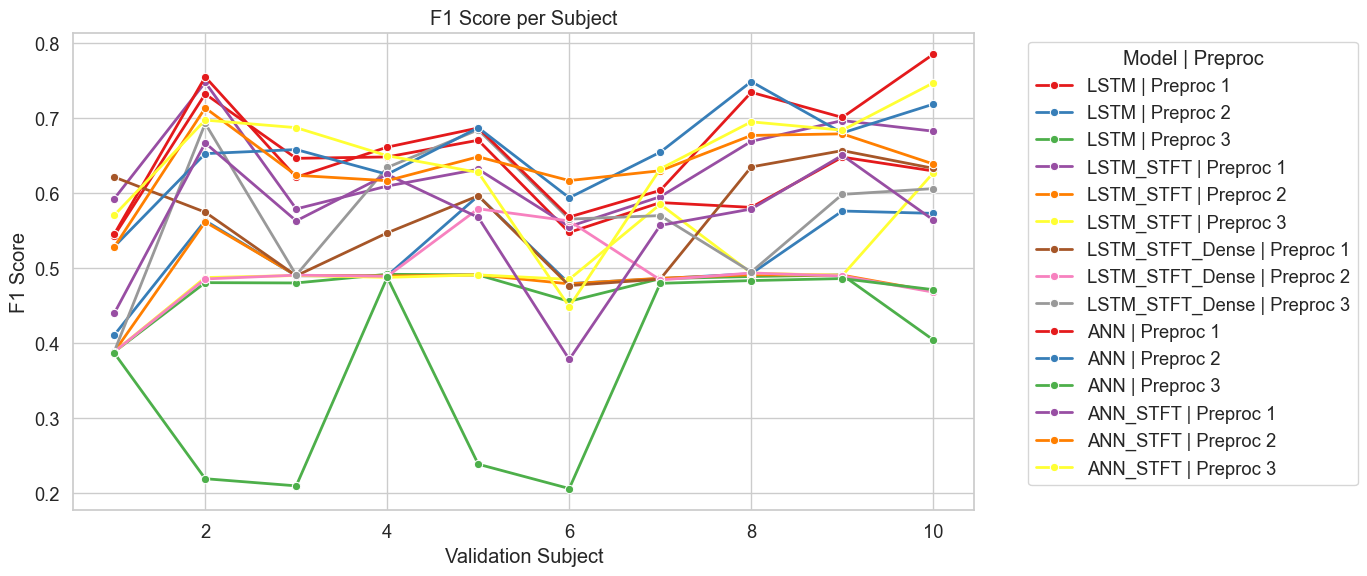

In [14]:
df_all['label'] = df_all['model'] + ' | Preproc ' + df_all['preproc_variant'].astype(str)

sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set1", n_colors=df_all['label'].nunique())

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_all,
    x='val_subject',
    y='f1',
    hue='label',
    palette=palette,
    marker='o',
    linewidth=2
)

plt.title('F1 Score per Subject')
plt.xlabel('Validation Subject')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend(title='Model | Preproc', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

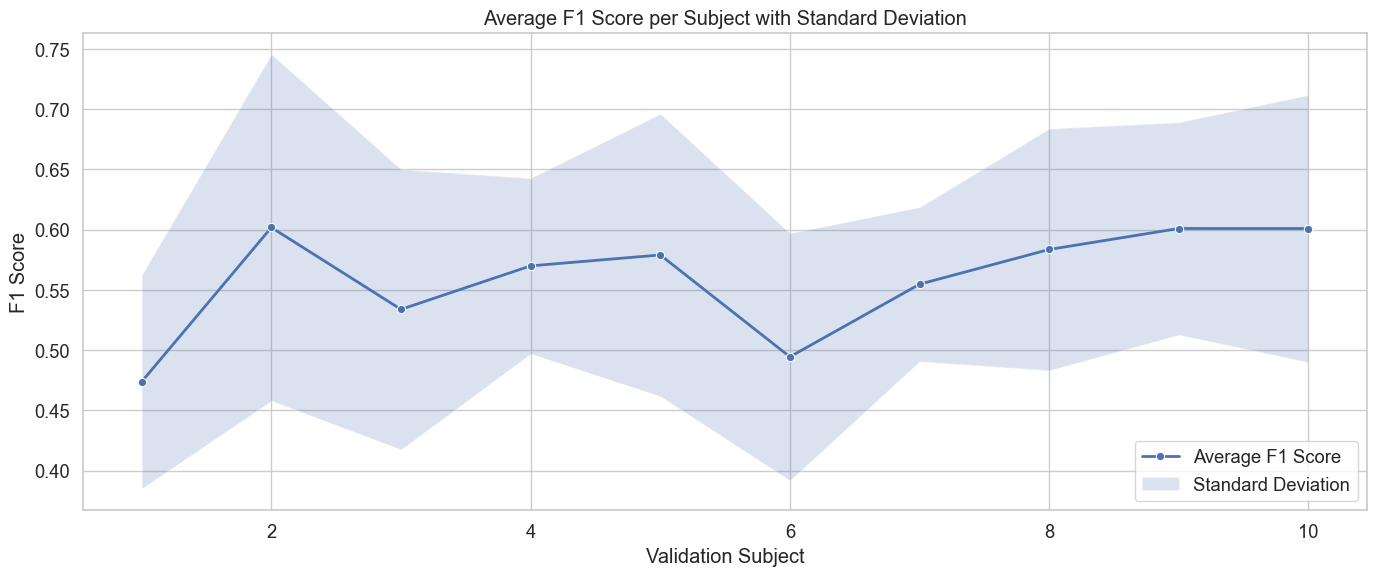

In [15]:
# Calculate mean and standard deviation for each subject
subject_stats = df_all.groupby('val_subject')['f1'].agg(['mean', 'std']).reset_index()

# Plot the average F1 score with standard deviation as a shaded area
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=subject_stats,
    x='val_subject',
    y='mean',
    marker='o',
    linewidth=2,
    label='Average F1 Score'
)

# Add shaded area for standard deviation
plt.fill_between(
    subject_stats['val_subject'],
    subject_stats['mean'] - subject_stats['std'],
    subject_stats['mean'] + subject_stats['std'],
    alpha=0.2,
    label='Standard Deviation'
)

plt.title('Average F1 Score per Subject with Standard Deviation')
plt.xlabel('Validation Subject')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Group by preproc_variant

In [16]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

In [17]:
# Group by preproc_variant and calculate statistics for all models
summary_stats_all = df_all.groupby('preproc_variant')['f1'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

# Filter models with "STFT" in the name
df_stft = df_all[df_all['model'].str.contains("STFT")]
summary_stats_stft = df_stft.groupby('preproc_variant')['f1'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

# Filter models without "STFT" in the name
df_non_stft = df_all[~df_all['model'].str.contains("STFT")]
summary_stats_non_stft = df_non_stft.groupby('preproc_variant')['f1'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

# Print the results
print("Summary statistics for all models:")
print(summary_stats_all)

print("\nSummary statistics for models with 'STFT':")
print(summary_stats_stft)

print("\nSummary statistics for models without 'STFT':")
print(summary_stats_non_stft)

Summary statistics for all models:
   preproc_variant      mean       std       min       max    median
0                1  0.610898  0.080402  0.378147  0.784638  0.614951
1                2  0.556613  0.090181  0.388281  0.748210  0.544838
2                3  0.510098  0.126952  0.206213  0.746497  0.490208

Summary statistics for models with 'STFT':
   preproc_variant      mean       std       min       max    median
0                1  0.588549  0.078945  0.378147  0.747199  0.593535
1                2  0.537732  0.084995  0.388281  0.713125  0.490873
2                3  0.572716  0.098049  0.388281  0.746497  0.577501

Summary statistics for models without 'STFT':
   preproc_variant      mean       std       min       max    median
0                1  0.644421  0.072024  0.542928  0.784638  0.646808
1                2  0.584935  0.092411  0.410551  0.748210  0.584658
2                3  0.416171  0.106832  0.206213  0.491570  0.479774


lineplot

In [18]:
import pandas as pd

summary = df_all.groupby(['model', 'preproc_variant'])['f1'].agg(['mean', 'std']).reset_index()

# Rename columns
summary.columns = ['Model', 'Preprocessing Variant', 'Average F1', 'Standard Deviation']

# Format the output nicely (rounded values)
summary['Average F1'] = summary['Average F1'].apply(lambda x: f"{x:.3f}")
summary['Standard Deviation'] = summary['Standard Deviation'].apply(lambda x: f"{x:.3f}")

# Sort for readability
summary = summary.sort_values(by=['Model', 'Preprocessing Variant'])

# Print clean table
print("\n F1 Score Summary by Model and Preprocessing Variant\n")
print(summary.to_string(index=False))



 F1 Score Summary by Model and Preprocessing Variant

          Model  Preprocessing Variant Average F1 Standard Deviation
            ANN                      1      0.666              0.081
            ANN                      2      0.654              0.062
            ANN                      3      0.367              0.131
       ANN_STFT                      1      0.559              0.089
       ANN_STFT                      2      0.637              0.050
       ANN_STFT                      3      0.644              0.084
           LSTM                      1      0.623              0.059
           LSTM                      2      0.515              0.058
           LSTM                      3      0.466              0.038
      LSTM_STFT                      1      0.636              0.061
      LSTM_STFT                      2      0.483              0.042
      LSTM_STFT                      3      0.502              0.064
LSTM_STFT_Dense                      1      0.57